# Pokémon Data Analysis

Spring 2025 Data Science Project

Laura Lai, Jessie Kim, Danny Pham, Anjali Venkatesh

---

## Contributions

**Laura Lai:**

Project idea - Assembled team and helped come up with the idea for the project. 

Data Exploration and Summary Statistics - Performed a chi-square test to determine if there was a statistically significant difference in the amount of Psychic-types released in the generations.

Final Tutorial Report Creation - Wrote the Insights and Conclusions sections of the report.


**Jessie Kim:**

Dataset Curation and Preprocessing- Fetched and extracted the features of the PokeAPI data and did the necessary preprocessing to convert it into a DataFrame. 

ML Algorithm Design/Development- Designed the ML Algorithm using KMeans and PC components, and curated the DataFrame with the features for the clustering. 

Final Tutorial Report Creation- Created the pages website for the ipynb file and uploaded the files.


**Danny Pham:**

Data Exploration and Summary Statistics - Performed ANOVA test to determine if there was a statistically significant different between the attributes of the top three pokemon types.

ML Algorithm Design/ Development - Found the optimal PC components by setting a variance threshold. (Note that the PCA performed with 2 components was completed by Jessie, but PCA performed by 3 was written by me)

Visualization, Result Analysis, Conclusion - Plotted PC components in 3D.


**Anjali Venkatesh:**

Project Idea - Found PokeAPI dataset

Data Exploration and Summary Stats - Made boxplots of all pokemon stats to view spread and variation in each.

Visualization, Result Analysis, Conclusion - Made grouped bar chart of kmeans clusters post PCA to check whether powercreep occurred and hypothesis was correct.

Final Tutorial Report Creation: Wrote Introduction section.


## Introduction

Pokemon has been a mainstay franchise for many years, releasing hundreds of new Pokemon across multiple generations. Each Pokemon has its own types, abilities, and other stats that determine its viability in the games. 

In some games that continually release new content, a phenomenon known as 'powercreep' has been observed. Powercreep is a gradual unbalancing where newer content becomes consistently more powerful than older content, making older content feel underpowered or obsolete. This is a problem for older players, as they must constantly update their resources to be able to play the game and can get frustrated when their older favorites feel less powerful.

In this project, we aim to determine whether Pokemon has been subject to power creep, ie: whether newer Pokemon are overall more powerful than older ones. This analysis could be used to inform players of the game, and any future development on the game to either mitigate or account for the imbalance.

We do this by exploring patterns and trends in different archetypes such as attackers and defenders throughout the first four Pokemon generations.

## Data Sources

PokeAPI: https://pokeapi.co/

A database containing everything Pokemon, including each individual Pokemon stats, abilities, generation number, etc.

---

## Data Curation and Processing

This module and the one below are run to fetch the data from the URL and convert it into a DataFrame.

In [5]:
# Importing all essential libraries
import pandas as pd
import numpy as np
import scipy.stats as stats 
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

In [6]:
# Function to fetch a Pokemon's data
def fetch_pokemon_data(pokemon):
    # Extract the pokemon's data
    pokemon_url = pokemon["url"]
    pokemon_resp = requests.get(pokemon_url)
    pokemon_data = pokemon_resp.json()

    # Extracting the pokemon's name, type, and stats from pokemon_data
    name = pokemon_data["name"]
    types = [type['type']['name'] for type in pokemon_data["types"]] # get all types if a pokemon has multiple types
    stats = {stat["stat"]["name"]: stat["base_stat"] for stat in pokemon_data["stats"]} # get all stats as a dictionary (stat["stat"]["name"]: stat["base_stat"] creates a key-value pair in which the name is the key and the base stat is the value)

    # Extracting the pokemon's generation number
    species_url = pokemon_data["species"]["url"]
    species_resp = requests.get(species_url)
    species_data = species_resp.json()
    generation = species_data["generation"]["name"] 

    generation_num = generation.split("-")[-1] # retrieves the last elem of the list generated by split (the roman numeral)
    generation_roman_lst = ["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix"]

    if generation_num in generation_roman_lst:
        index = generation_roman_lst.index(generation_num)
        generation_num = int(generation_num.replace(generation_roman_lst[index], str(index + 1)))

    # Add Pokemon's name and types into the stats dictionary (ensuring they're there if not)
    stats["name"] = name
    stats["types"] = types
    stats["generation"] = generation_num

    return stats # returns as a dictionary
    

In [7]:
# Fetching the API (we are only looking at the first 493 Pokemon, Gens 1-4)
api_url = "https://pokeapi.co/api/v2/pokemon?limit=493&offset=0"
response = requests.get(api_url)
pokeapi_data = response.json()

# Creating a list which will store all the Pokemons' information
pokemon_list = []

# Loop which will fetch each Pokemons' data and append it to a list
for pokemon in pokeapi_data["results"]:
    pokemon_entry = fetch_pokemon_data(pokemon)
    pokemon_list.append(pokemon_entry)

# Convert the list to a DataFrame
pokemon_df = pd.DataFrame(pokemon_list)
pokemon_df = pokemon_df[["name", "types", "generation", "hp", "attack", "defense", "special-attack", "special-defense", "speed"]]
pokemon_df

,name,types,generation,hp,attack,defense,special-attack,special-defense,speed
0,bulbasaur,"[grass, poison]",1,45,49,49,65,65,45
1,ivysaur,"[grass, poison]",1,60,62,63,80,80,60
2,venusaur,"[grass, poison]",1,80,82,83,100,100,80
3,charmander,[fire],1,39,52,43,60,50,65
4,charmeleon,[fire],1,58,64,58,80,65,80
...,...,...,...,...,...,...,...,...,...
488,phione,[water],4,80,80,80,80,80,80
489,manaphy,[water],4,100,100,100,100,100,100
490,darkrai,[dark],4,70,90,90,135,90,125
491,shaymin-land,[grass],4,100,100,100,100,100,100


A Pokemon's generation broadly defines its release date, with older pokemon being generation 1, and newest being generation 4. 

In [8]:
# Describes the Pokemon DataFrame
pokemon_df.describe()

,generation,hp,attack,defense,special-attack,special-defense,speed
count,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000,493.000000
mean,2.401623,67.912779,73.608519,70.231237,68.133874,69.259635,65.561866
std,1.135602,27.613228,29.209693,30.682469,28.573296,27.883350,27.340646
min,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,1.000000,50.000000,50.000000,50.000000,45.000000,50.000000,45.000000
50%,2.000000,65.000000,72.000000,65.000000,65.000000,65.000000,65.000000
75%,3.000000,80.000000,92.000000,85.000000,90.000000,85.000000,85.000000
max,4.000000,255.000000,165.000000,230.000000,154.000000,230.000000,160.000000


In [9]:
# Displaying the count to check for missing values
display(pokemon_df.count())
display(pokeapi_data["count"])

name               493
types              493
generation         493
hp                 493
attack             493
defense            493
special-attack     493
special-defense    493
speed              493
dtype: int64

1302

---

## Exploratory Analysis

**Box Plots**

Using box plots, we want to vizualize the spread and skewness of each pokemon stat, and identify any potential outliers in each.

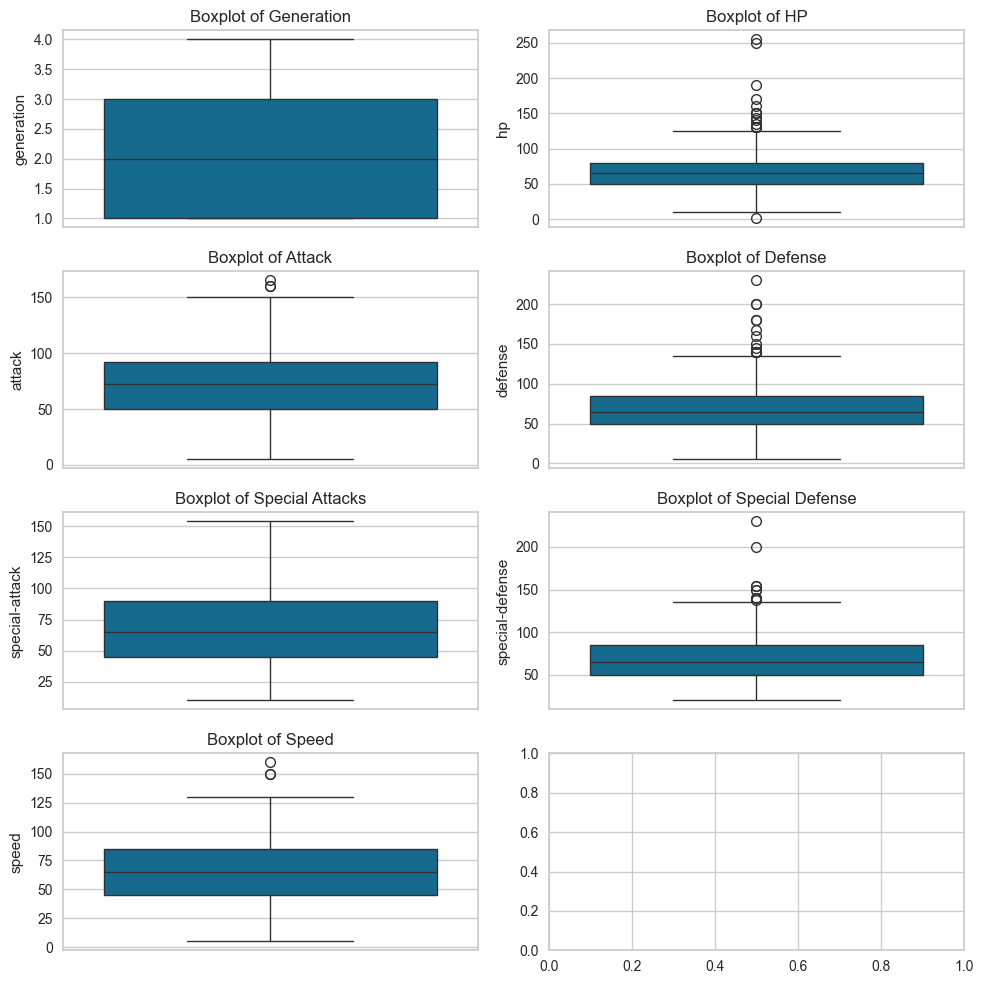

In [10]:
# Creating boxplots

fig, axes = plt.subplots(4, 2, figsize=(10, 10))

sns.boxplot(y=pokemon_df['generation'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Generation')

sns.boxplot(y=pokemon_df['hp'], ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of HP')

sns.boxplot(y=pokemon_df['attack'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Attack')

sns.boxplot(y=pokemon_df['defense'], ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Defense')

sns.boxplot(y=pokemon_df['special-attack'], ax=axes[2, 0])
axes[2, 0].set_title('Boxplot of Special Attacks')

sns.boxplot(y=pokemon_df['special-defense'], ax=axes[2, 1])
axes[2, 1].set_title('Boxplot of Special Defense')

sns.boxplot(y=pokemon_df['speed'], ax=axes[3, 0])
axes[3, 0].set_title('Boxplot of Speed')

plt.tight_layout()
plt.show()


From this, we get the following conclusions:

Generation: Most Pokemon are from generations 1-3, with most being generation 2.

HP: HP has many outliers, but most lie in the 0-150 range, with the median being around 60.

Attack: Has 2 outliers, between the range of 0-150, most lie around 50-90, with a median of 75.

Defense: Has many outliers, between the range of 0-150, most lie around 50-85, with a median of about 60.

Special Attack: Has no outliers, between 20-150, most lie around 45-95, with a median of about 60.

Special Defense: Has many outliers on the higher side, between 25-140, most lie around 50-95, with a median of about 60.

Speed: Has 2 outliers on higher side, between 5-125, most lie around 45-85, with a median of about 60.

**Chi-Squared Test**

Next, we want to see if there is a relationship between the generation number and number of Psychic-type Pokemon (including double types) released in the dataset. To do so, we perform a chi-squared test for independence with alpha = 0.05.  

**H_0:** There is no relationship between generation and the number of Psychic-type Pokemon introduced.

**H_A:** There is a relationship between generation and the number of Psychic-type Pokemon introduced.

Chi-Squared Value: 3.3374086991088974
P-value: 0.3424698957777506
Degrees of Freedom: 3
Expected Frequencies Table:
[[134.76673428  16.23326572]
 [ 89.2494929   10.7505071 ]
 [120.48681542  14.51318458]
 [ 95.4969574   11.5030426 ]]


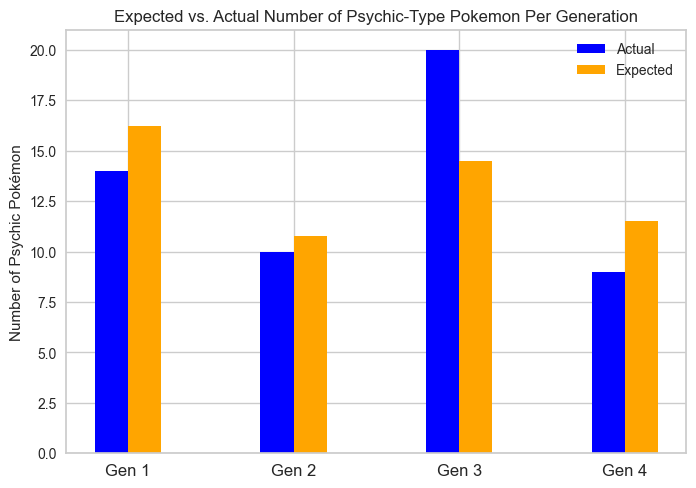

In [11]:
# create a column indicating if a Pokemon has the Psychic type
pokemon_df['is_psychic'] = pokemon_df['types'].apply(lambda x: 'psychic' in x)

# Now create a contingency table comparing generation & Psychic-type status
contingency_table = pd.crosstab(pokemon_df['generation'], pokemon_df['is_psychic'])

# perform chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Squared Value: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies Table:")
print(expected)

# plot expected # of Psychic types with the actual # of Psychic types
labels = ['Gen 1', 'Gen 2', 'Gen 3', 'Gen 4']
width = 0.2
x = np.arange(len(labels))
plt.xticks(x, labels, fontsize=12)

expected_psychic = expected[:, 1].tolist()
actual_psychic = [pokemon_df[pokemon_df['generation'] == 1]['is_psychic'].sum(),
                  pokemon_df[pokemon_df['generation'] == 2]['is_psychic'].sum(),
                  pokemon_df[pokemon_df['generation'] == 3]['is_psychic'].sum(),
                  pokemon_df[pokemon_df['generation'] == 4]['is_psychic'].sum()]
plt.bar(x - width/2, actual_psychic, width=width, label='Actual', color='blue', edgecolor=None)
plt.bar(x + width/2, expected_psychic, width=width, label='Expected', color='orange',edgecolor=None)
plt.ylabel("Number of Psychic Pokémon")
plt.title("Expected vs. Actual Number of Psychic-Type Pokemon Per Generation")
plt.legend()
plt.show()


Since the p-value is greater than 0.05, we fail to reject the null hypothesis. There is not sufficient evidence to prove that there is a relationship between generation number and number of Psychic-types released.

**ANOVA Test**

We want to see if there is a significant difference between the attributes of the top three Pokemon types. To do so we perform an ANOVA test with an alpha of 0.05.

**H_0:** There is no difference between the attributes of the top three Pokemon types.

**H_A:** There is a difference between the attributes of the top three Pokemon types.

In [12]:
# Finding the top 3 most popular types
pokemon_df['types'].explode() \
                   .value_counts()[:3]

types
water     92
normal    72
flying    64
Name: count, dtype: int64

In [13]:
# Cleaning attributes to set up for ANOVA
anova_attrs = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

water_types = pokemon_df[pokemon_df['types'].apply(lambda x: any(i == 'water' for i in x))][anova_attrs]
normal_types = pokemon_df[pokemon_df['types'].apply(lambda x: any(i == 'normal' for i in x))][anova_attrs]
flying_types = pokemon_df[pokemon_df['types'].apply(lambda x: any(i == 'flying' for i in x))][anova_attrs]

In [14]:
# Performing ANOVA test
statistic, pvalue = stats.f_oneway(water_types, normal_types, flying_types)
print(f"Statistic: {statistic}]\nP-value: {pvalue}")

Statistic: [ 1.93045095  0.22567406  7.9856803   7.71162871  2.58241603 11.17270117]]
P-value: [1.47478161e-01 7.98158558e-01 4.46089942e-04 5.76341151e-04
 7.78304526e-02 2.36510839e-05]


In [15]:
significant_diff = [i < 0.05 for i in pvalue]

<Axes: title={'center': 'ANOVA Test Features and P-Values'}, xlabel='Features', ylabel='P-Values'>

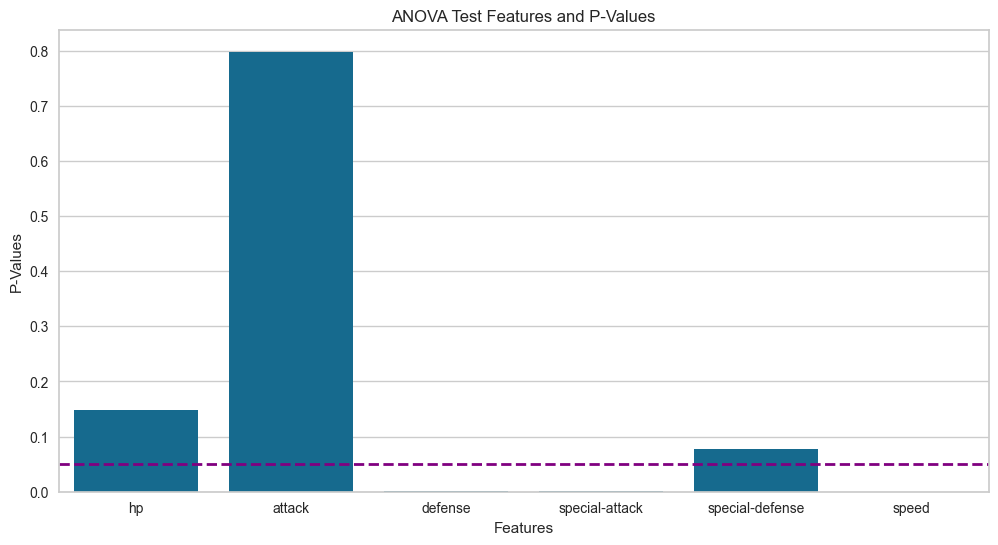

In [16]:
data = {
   "Features" : anova_attrs,
   "P-Values" : list(pvalue)
}

plt.figure(figsize=(12,6))
plt.axhline(y=0.05, color="purple", linestyle="--", linewidth=2)
plt.title("ANOVA Test Features and P-Values")
sns.barplot(data=data, x="Features", y="P-Values")

Here we can see that there exist a significant difference between the defense, special-attack, and speed attributes as those have a p-value below 0.05. We can perform some form of Post-HOC test to see which combinations of types are statistically significant.

## Primary Analysis

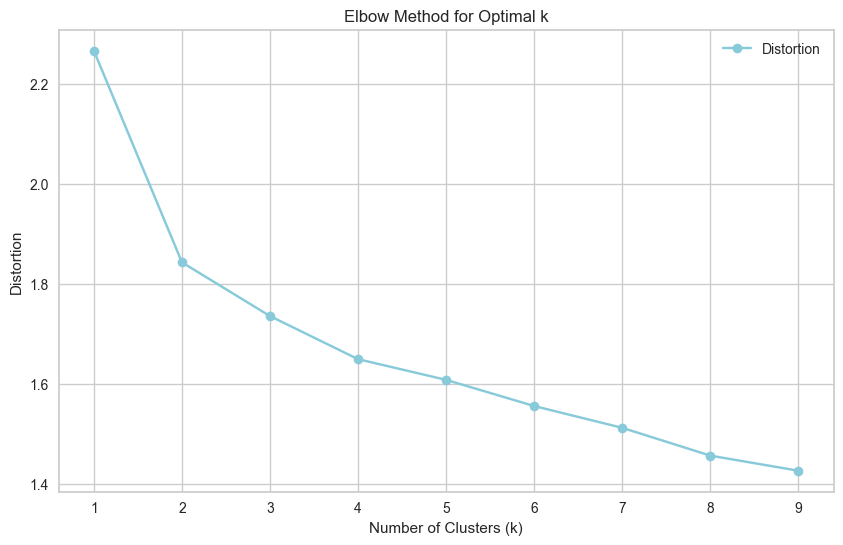

In [17]:
seed = 42

# Retrieve stat columns
X = pokemon_df[["hp", "attack", "defense", "special-attack", "special-defense", "speed"]]

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding optimal K (elbow method)
distortions = []
K = range(1, 10)

for k in K:
    k_means = KMeans(n_clusters=k, random_state=seed, n_init=10) # initialize k means
    k_means.fit(X_scaled) # fit k means

    # The sum of squared distances of each pt to its centroid of the assigned i-th cluster
    N = X_scaled.shape[0]
    distortion = (1/N) * np.sum(np.min(k_means.transform(X_scaled), axis=1))
    distortions.append(distortion)

plt.figure(figsize=(10,6))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distortion")
plt.title("Elbow Method for Optimal k")
plt.plot(K, distortions, 'co-', label="Distortion")
plt.legend()
plt.show()

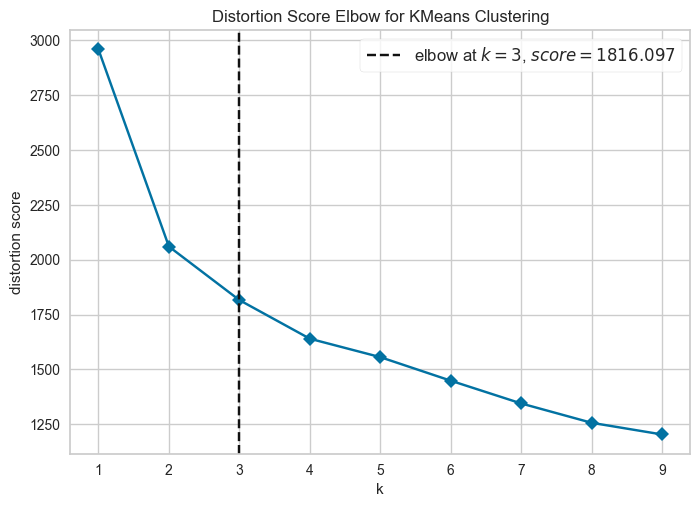

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=seed)
visualizer = KElbowVisualizer(model, k=(1,10), timings=False)

visualizer.fit(X_scaled)
visualizer.show()

In [19]:
# Choosing 3 as k for K-Means based on Elbow Method
k_cluster = 3
# The random state which we will be using for the remainder of this analysis
seed = 42

### PCA

Selecting the number of PCs that describe at least 80% of the variance

In [20]:
X_scaled.shape[1]

6

In [21]:
covar_matrix = PCA(n_components=X_scaled.shape[1])
model = covar_matrix.fit(X_scaled)

var = np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3) * 100)

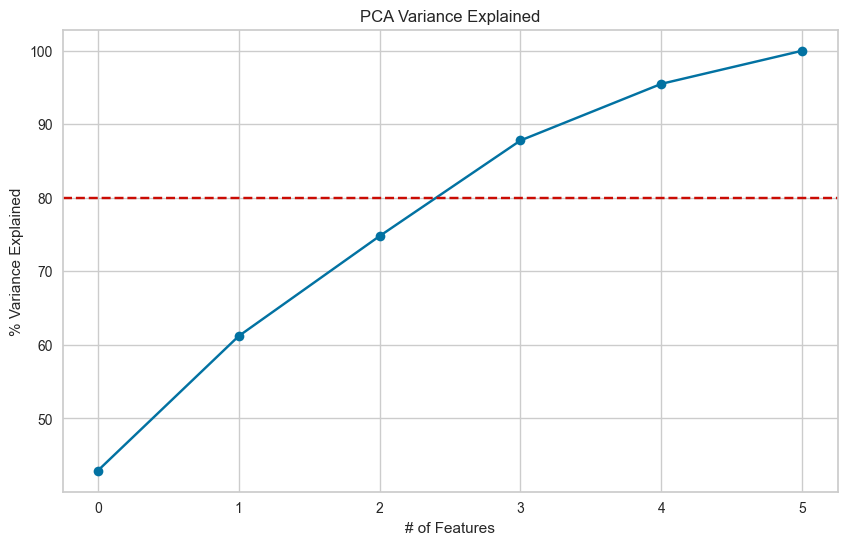

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(var, marker='o', linestyle='-', color='b')

plt.axhline(y=80, color='r', linestyle='--')

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Variance Explained')

plt.show()

Here we select 3 components for PCA. (Note that we have two visualizations below representing 2 and 3 components respectively)

In [23]:
# Function that applies PCA and returns transformed data
def apply_pca(X_scaled, n_components):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X_scaled)

    return pca, X_pca

In [24]:
# Function that applies K-Means clustering and returns the labels
def apply_kmeans(X, n_clusters, random_state=seed):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    labels = kmeans.labels_

    return labels

In [25]:
# Function that visualizes the clusters
def plot_clusters(df, labels, title, xlabel, ylabel):
    df = df.copy()
    df["cluster"] = pd.Categorical(labels)

    fig = plt.subplots(figsize=(10,6))
    sns.scatterplot(x='PC1', y='PC2', hue="cluster", data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title="Cluster")
    plt.show()

### Visualizing PCA in Two Dimensions

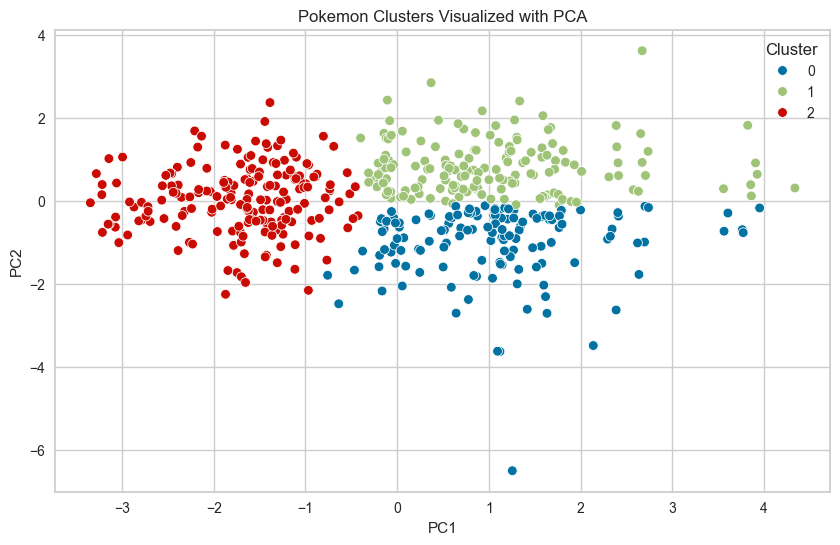

In [26]:
# Apply PCA
pca, X_pca = apply_pca(X_scaled, n_components=2)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

# Apply K-Means
kmeans_labels = apply_kmeans(X_pca, n_clusters=k_cluster, random_state=seed)

# Plot clusters
plot_clusters(pca_df, kmeans_labels, "Pokemon Clusters Visualized with PCA", "PC1", "PC2")


### Visualizing PCA in Three Dimensions

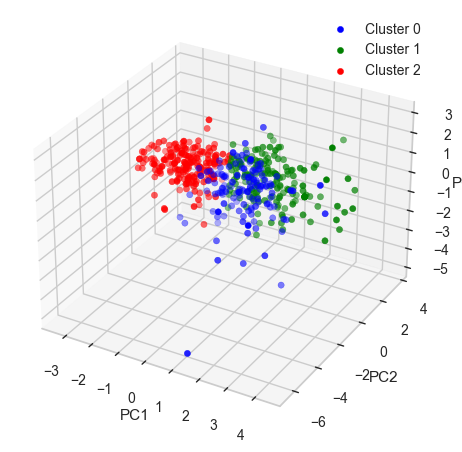

In [27]:
# Apply PCA
pca, X_pca = apply_pca(X_scaled, n_components=3)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])

# Apply K-Means
kmeans_labels = apply_kmeans(X_pca, n_clusters=k_cluster, random_state=seed)
pca_df['Labels'] = pd.Categorical(kmeans_labels)

# Plot clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cluster_colors = {0: 'blue', 1: 'green', 2: 'red'}

for label in range(3):
    cluster_data = pca_df[pca_df['Labels'] == label]
    ax.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        cluster_data['PC3'],
        label=f'Cluster {label}',
        color=cluster_colors[label]
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()

plt.show()



The clusters above represent different categories of Pokemon based on their stats. 

cluster 0: potentially sweeper pokemon. This includes the most powerful Pokemon who have high stats and high battle prowess.

cluster 1: potentially tanks/supports. This includes Pokemon with more specialized stats (ex. a Pokemon with high HP but lower Attack).

cluster 2: potentially weaker/early stage pokemon. This includes Pokemon who have low stats and are less effective in battle scenarios. 

clusters can help categorize kinds of pokemon other than their classified types

### Analyzing for Power Creep
Now we compare the cluster label to the Pokemon's generation. If there has been power creep, we hypothesize that higher generation pokemon will belong to cluster 0, and lower generation pokemon will belong to cluster 2.

In [ ]:
# Adding back kmeans cluster labels to the original df.
pokemon_df["cluster"] = kmeans_labels
pokemon_df.head()

,name,types,generation,hp,attack,defense,special-attack,special-defense,speed,is_psychic,cluster
0,bulbasaur,"[grass, poison]",1,45,49,49,65,65,45,False,2
1,ivysaur,"[grass, poison]",1,60,62,63,80,80,60,False,1
2,venusaur,"[grass, poison]",1,80,82,83,100,100,80,False,1
3,charmander,[fire],1,39,52,43,60,50,65,False,2
4,charmeleon,[fire],1,58,64,58,80,65,80,False,1


In [ ]:
gen_counts = pokemon_df.groupby(['generation']).size().reset_index(name='count')
gen_counts

,generation,count
0,1,151
1,2,100
2,3,135
3,4,107


Each generation of pokemon released had a different number of pokemon. So, we will use the relative frequency of each cluster within each generation to accurately determine whether newer generations have a greater proportion of powerful (clusters 0 and 1) pokemon.

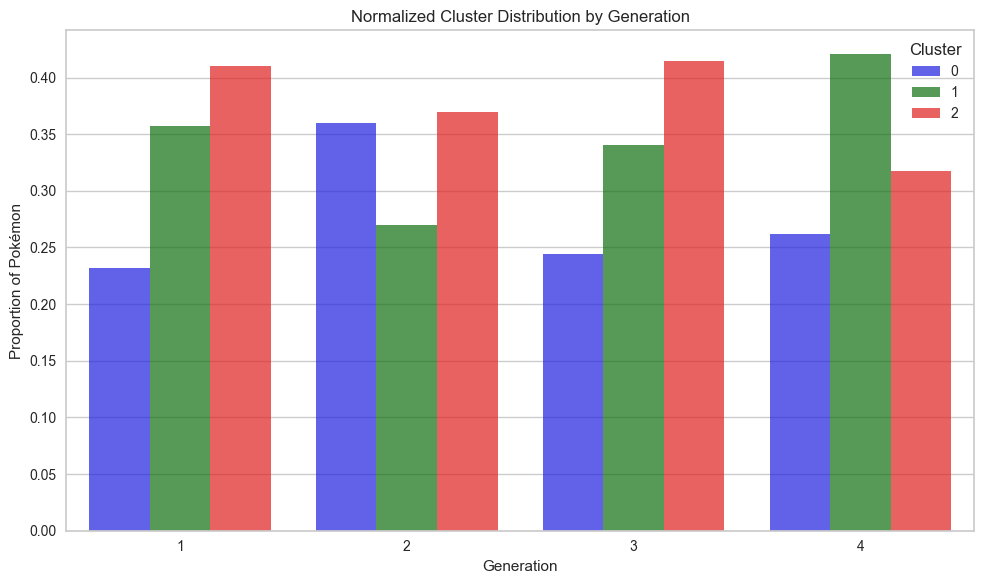

In [ ]:

# Counts per generation and cluster
cluster_counts = pokemon_df.groupby(['generation', 'cluster']).size().reset_index(name='count')

# Total pokemon in each generation
total_per_gen = cluster_counts.groupby('generation')['count'].transform('sum')

# Calculate relative frequency
cluster_counts['normalized'] = cluster_counts['count'] / total_per_gen

plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_counts, x='generation', y='normalized', hue='cluster', palette=cluster_colors, alpha=0.7)

plt.title('Normalized Cluster Distribution by Generation')
plt.xlabel('Generation')
plt.ylabel('Proportion of Pokémon')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

From this graph, we can see that power creep has indeed occurred, as newer generations (3 and 4) have the highest frequencies of powerful pokemon.

### Insights:
As mentioned above, our analysis shows that there is evidence for powercreep from the first to the fourth generation of Pokemon releases. There are a few potential reasons why this could have happened:

1. The company wants to attract new players by making the overall power level of the Pokemon available stronger. 
2. Developers might want to create new content that doesn't feel repetitive.
3. For the first games, the developers may not have fully thought of all the possible combinations of Pokemon and their stats, resulting in more "weaker" Pokemon.

However, if this trend continues and future Pokemon continue getting stronger, players may start feeling disillusioned with the Pokemon franchise.

### Conclusion:

Throughout its first four iterations, Pokemon have gradually become stronger and more specialized. This is evident when comparing the proportions of sweeper and tank Pokemon in generations 1 and 2 versus the proportions of sweeper and tank Pokemon in generations 3 and 4. 

Avid Pokemon fans may have already noticed this slow powercreep because they regularly play the games and may notice if or when newer releases overpower older ones. This data helps quantify the degree to which powercreep has actually occurred.